In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pickle
from scipy import interpolate
from qmsc.ansatz import FlexibleAnsatz
import qiskit
import fnmatch

In [2]:
matplotlib.style.use("./style.mplstyle")
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{amsmath}\usepackage{amsfonts}")
#matplotlib.verbose.level = 'debug-annoying'

## XY state epsilon-rank plots

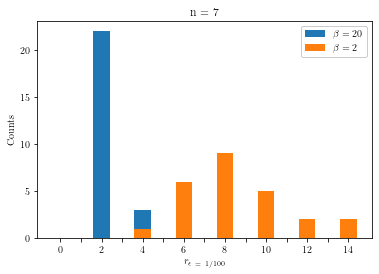

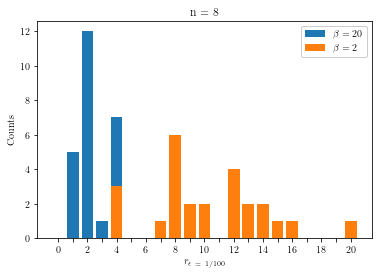

In [3]:
dir_name = "../publication_script/bash_submissions"

low_T_xy_fname = f"{dir_name}/random_xy_T_0.05_states.pkl"
with open(low_T_xy_fname, 'rb') as f:
    low_T_xy_data = pickle.load(f)
    
high_T_xy_fname = f"{dir_name}/random_xy_T_0.5_states.pkl"
with open(high_T_xy_fname, 'rb') as f:
    high_T_xy_data = pickle.load(f)
    
bures_fname = f"{dir_name}/random_bures_states.pkl"
with open(bures_fname, 'rb') as f:
    bures_data = pickle.load(f)
    
n = 7

low_T_eps_rank = []
for j in range(25):
    r_eps = low_T_xy_data[(n, 0.05, j)][1]
    low_T_eps_rank.append(r_eps)
    
high_T_eps_rank = []
for j in range(25):
    r_eps = high_T_xy_data[(n, 0.5, j)][1]
    high_T_eps_rank.append(r_eps)
    
low_counts = list(np.bincount(low_T_eps_rank))
high_counts = list(np.bincount(high_T_eps_rank))

# pad low with high 0's
x = list(range(len(high_counts)))
for j in range(len(x) - len(low_counts)):
    low_counts.append(0)
xlabels = []
for xj in x:
    if xj % 2 == 0:
        xlabels.append(str(xj))
    else:
        xlabels.append("")
        
        
plt.bar(x, low_counts, label=r"$\beta = 20$")
plt.bar(x, high_counts, label=r"$\beta = 2$")
plt.xticks(x, xlabels)
plt.xlabel(r"$r_{\epsilon \ = \ 1/100}$")
plt.ylabel("Counts")
plt.title("n = 7")
plt.legend()
plt.savefig("plots/xy_thermal_reps_dist_n_7.pdf", dpi=800, bbox_inches='tight')
plt.show()

n = 8
low_T_eps_rank = []
for j in range(25):
    r_eps = low_T_xy_data[(n, 0.05, j)][1]
    low_T_eps_rank.append(r_eps)
    
high_T_eps_rank = []
for j in range(25):
    r_eps = high_T_xy_data[(n, 0.5, j)][1]
    high_T_eps_rank.append(r_eps)
    
low_counts = list(np.bincount(low_T_eps_rank))
high_counts = list(np.bincount(high_T_eps_rank))

# pad low with high 0's
x = list(range(len(high_counts)))
for j in range(len(x) - len(low_counts)):
    low_counts.append(0)
xlabels = []
for xj in x:
    if xj % 2 == 0:
        xlabels.append(str(xj))
    else:
        xlabels.append("")
        
plt.bar(x, low_counts, label=r"$\beta = 20$")
plt.bar(x, high_counts, label=r"$\beta = 2$")
plt.xticks(x, xlabels)
plt.xlabel(r"$r_{\epsilon \ = \ 1/100}$")
plt.ylabel("Counts")
plt.title("n = 8")
plt.legend()
plt.savefig("plots/xy_thermal_reps_dist_n_8.pdf", dpi=800, bbox_inches='tight')
plt.show()

## XY example optimization plots

/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_21256/497689261.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ydata = np.array(list(clipped_data.values()))


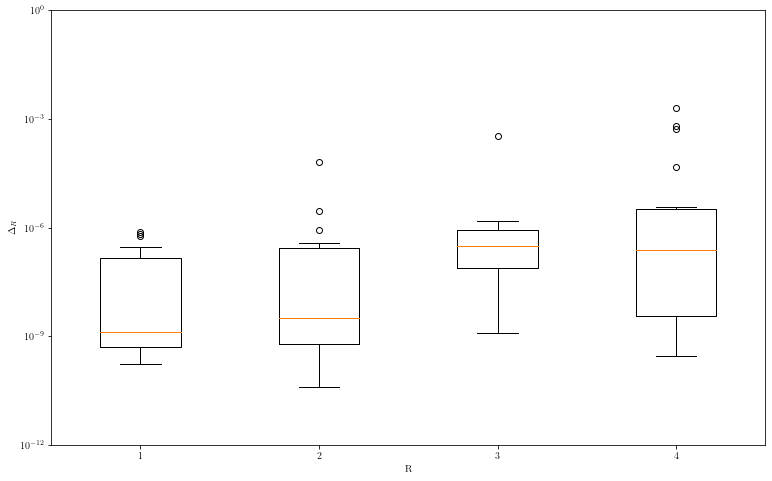

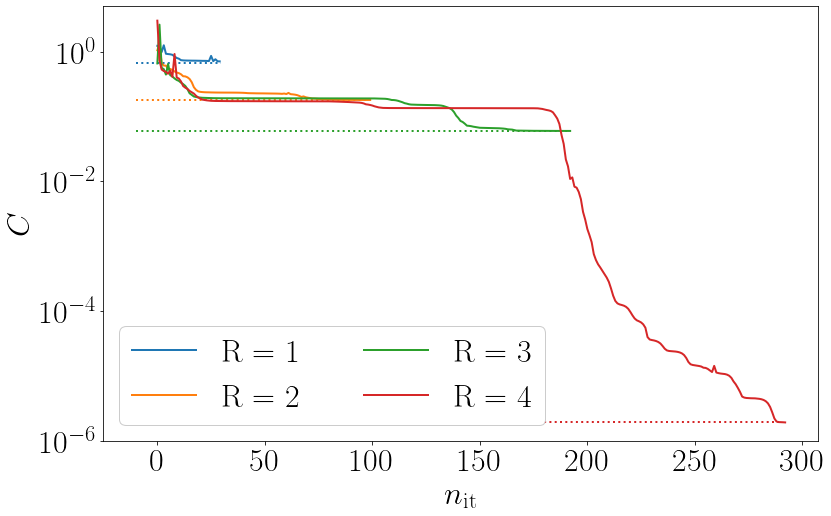

In [4]:
data_dir = "extra_xy_rand_thermal_data"
fnames = glob.glob(f"{data_dir}/*.pkl")
rand_fnames = [f for f in fnames if "rand_1" in f]
static_fnames = [f for f in fnames if "rand_1" not in f]

def extract_params(data):
    """
    Extract ns, T, and re
    from the keys of [data].
    """
    key = list(data.keys())[0]
    split = key.split('_')
    ns_idx = split.index('ns')
    ns = int(split[ns_idx + 1])
    T_idx = split.index('T')
    T = float(split[T_idx + 1])
    re_idx = split.index('re')
    re = int(split[re_idx + 1])
    
    return ns, T, re

def load_file(fname):
    """
    Extract baby.
    """
    summ_data = {}
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    ns, T, re = extract_params(data)
    # extract costs for R = 1, 2, 3, 4
    for R in [1, 2, 3, 4]:
        try:
            cost_key = f"costs_ns_{ns}_T_{T}_re_{re}_R_{R}"
            costs = data[cost_key]
            opt_key = f"optDHS_ns_{ns}_T_{T}_re_{re}_R_{R}"
            opt_cost = data[opt_key]
            nit_key = f"nit_ns_{ns}_T_{T}_re_{re}_R_{R}"
            nit = data[nit_key]
            summ_data[(ns, T, R)] = (costs, opt_cost, nit)
        except:
            continue
        
    return summ_data

def load_all_files(file_list):
    """
    Extract a lot.
    """
    summary_data = {}
    for fname in file_list:
        data = load_file(fname)
        # first add to summary_data
        key = list(data.keys())[0]
        ns, T, _ = key
        for R in [1, 2, 3, 4]:
            try:
                min_cost = np.min(data[(ns, T, R)][0])
                opt_cost = data[(ns, T, R)][1]
                diff = np.abs(min_cost - opt_cost)
                if (ns, T, R) in summary_data:
                    summary_data[(ns, T, R)].append(diff)
                else:
                    summary_data[(ns, T, R)] = [diff]
            except:
                continue
                
    return summary_data

def find_flatten_off_point(cost_list):
    """
    Truncates cost list at the point when
    it plaetues. Returns truncated list
    and fraction of truncated to total
    list length.
    """
    # find first index close to minimum
    min_cost = np.min(cost_list)
    close_idx = np.where(np.isclose(min_cost, cost_list, rtol=1e-3))[0][0]
    
    return cost_list[0:close_idx], (close_idx + 1) / len(cost_list)

def load_nit(file_list):
    """
    Extract a lot.
    """
    summary_data = {}
    for fname in file_list:
        data = load_file(fname)
        # first add to summary_data
        key = list(data.keys())[0]
        ns, T, _ = key
        for R in [1, 2, 3, 4]:
            try:
                costs, frac = find_flatten_off_point(data[(ns, T, R)][0])
                nit = data[(ns, T, R)][2]
                nit *= frac
                if (ns, T, R) in summary_data:
                    summary_data[(ns, T, R)].append(nit)
                else:
                    summary_data[(ns, T, R)] = [nit]
            except:
                continue
                
    return summary_data

def load_eps_rank(file_list):
    """
    Extract a lot.
    """
    eps_data = {}
    for fname in file_list:
        with open(fname, 'rb') as f:
            data = pickle.load(f)
            ns, T, re = extract_params(data)
            if (ns, T) not in eps_data:
                eps_data[(ns, T)] = [re]
            else:
                eps_data[(ns, T)].append(re)
                
    return eps_data

summary_data = load_all_files(rand_fnames)

nit_data = load_nit(rand_fnames)

eps_data = load_eps_rank(rand_fnames)

T = 0.25
n = 7
#R = 1
"""
clipped_data = {}
for key in summary_data:
    if key[0] <= 9 and key[1] == T and key[2] == R:
        clipped_data[key] = summary_data[key]
"""
clipped_data = {}
for key in summary_data:
    if key[0] == n and key[1] == T:
        clipped_data[key] = summary_data[key]

xlabels = list(clipped_data.keys())
xlabels = np.array([x[2] for x in xlabels])
idx_sort = np.argsort([ns for ns in xlabels])
xlabels = xlabels[idx_sort]

ydata = np.array(list(clipped_data.values()))
ydata = ydata[idx_sort]

ysize = 8
fig, ax = plt.subplots(figsize=(1.6*ysize, ysize))
ax.boxplot(ydata)
ax.set_xticklabels(xlabels)
plt.yscale("log")
plt.ylabel("$\Delta_R$")
plt.xlabel("R")
plt.ylim(1e-12, 1)
#plt.title(f"T = {T}; n = {n}")
#plt.title(f"Haar Random Ensembles; ns = {ns}")
plt.rcParams['font.size'] = 32
plt.savefig("plots/rand_XY_n7_summary.pdf", dpi=800, bbox_inches='tight')
plt.show()


n7_fnames = []
for fname in rand_fnames:
    if "ns_7" in fname:
        n7_fnames.append(fname)

data = load_file(n7_fnames[9])
ns = 7
T = 0.25
ysize = 8
fig, ax = plt.subplots(figsize=(1.6*ysize, ysize))
for R in [1, 2, 3, 4]:
    if R == 4:
        cost_data = data[(ns, T, R)][0]
        opt_cost = data[(ns, T, R)][1]
        nit = data[(ns, T, R)][2]
        nfenv = len(cost_data)
    elif R == 3:
        cost_data = data[(ns, T, R)][0]
        nfenv = int(len(cost_data) / 1.5)
        cost_data = cost_data[0:nfenv]
        opt_cost = data[(ns, T, R)][1]
        nit = data[(ns, T, R)][2] / 1.5
    elif R == 2:
        cost_data = data[(ns, T, R)][0]
        nfenv = int(len(cost_data) / 2.5)
        cost_data = cost_data[0:nfenv]
        opt_cost = data[(ns, T, R)][1]
        nit = data[(ns, T, R)][2] / 2.5
    else:
        cost_data = data[(ns, T, R)][0]
        nfenv = int(len(cost_data) / 2)
        cost_data = cost_data[0:nfenv]
        opt_cost = data[(ns, T, R)][1]
        nit = data[(ns, T, R)][2] / 2
    
    plt_data = cost_data[0:nfenv:int(nfenv / nit)]
    plt.plot(plt_data, c = new_colors[R - 1], label=f"R = {R}")
    plt.hlines(opt_cost, -10, nit, color = new_colors[R - 1], linestyles="dotted")
plt.yscale("log")
plt.ylabel(r"$C$")
plt.ylim(1e-6, 5)
plt.xlabel(r"$n_{\text{it}}$")
plt.legend(ncol=2)
plt.savefig("plots/rand_XY_n7_example_opt.pdf", dpi=800, bbox_inches='tight')
plt.show()

# Make lower rank hardware data plots

## Make $\rho_{\Phi_+}$, CCPS Plots

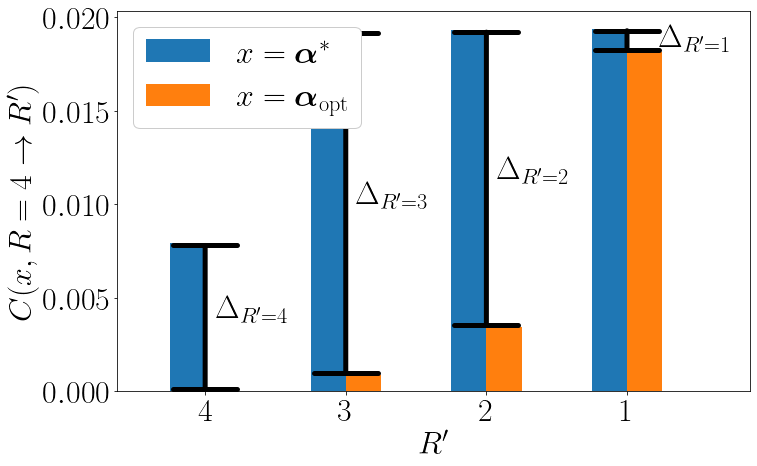

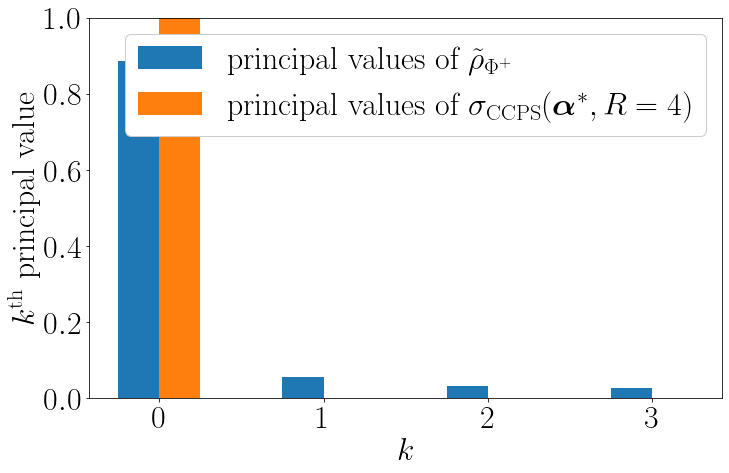

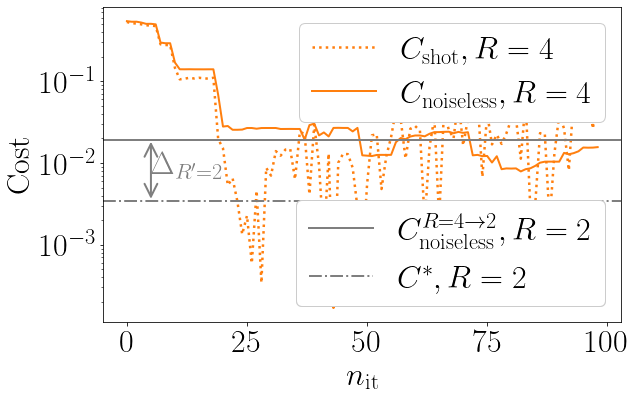

In [5]:
ddir1 = "hardware_implementation_data/hardware_state_CCPS_ansatz"
csv_files1 = glob.glob(f"{ddir1}/csv_runs/*")
pkl_files1 = glob.glob(f"{ddir1}/pickled_runs/*")

ddir2 = "hardware_implementation_data/hardware_state_SP_ansatz"
csv_files2 = glob.glob(f"{ddir2}/csv_runs/*")
pkl_files2 = glob.glob(f"{ddir2}/pickled_runs/*")

csv_files = csv_files1 + csv_files2
pkl_files = pkl_files1 + pkl_files2

csv_files = [csv_files[0], csv_files[2], csv_files[4]]

def get_rolling_mins(costs, window=10):
    """
    
    """
    mins = []
    bins = int(np.floor(len(costs) / window))
    for b in range(bins):
        cost_window = costs[b * window:(b + 1) * window]
        mins.append(min(cost_window))
        
    cost_window = costs[(bins + 1) * window:]
    if cost_window != []:
        mins.append(min(cost_window))
    
    return np.array(mins)

def compute_optimal_DHS(rho, R):
    """
    Computes D^*_HS when learning [rho]
    with a rank [R] approximation.
    """
    # compute \lambda's and sort them
    lam = np.sort(np.real(np.linalg.eigvals(rho)))
    d = len(lam)
    # compute lowest d - R lowest and R highest
    low_lam = np.array(lam[0:d-R])
    high_lam = np.array(lam[d-R:])
    N = (1 - np.sum(high_lam)) / R
    # compute cost
    #opt_DHS = np.sum(low_lam) + (1/R) * (1 - np.sum(high_lam))**2
    opt_DHS = np.sum(low_lam**2) +  R * N**2
    
    return opt_DHS

def make_data_dict(csv_files, pkl_files):
    """
    Makes a data dictionary for plotting purposes.
    """
    data_dict = {}
    for file in csv_files:
        # load in csv info
        shot_cost = []
        exact_cost = []
        with open(file, 'r') as f:
            for line in f.readlines():
                sc, ec = [float(z) for z in line.strip('\n').split(',')]
                shot_cost.append(sc)
                exact_cost.append(ec)
        # get associated pkl file with states/ metadata
        pkl_dir = "/".join(file.split("/")[0:2])+ "/pickled_runs/"
        pkl_f = file.split('/')[3][0:-4] + ".pkl"
        with open(pkl_dir + pkl_f, 'rb') as f:
            meta_data = pickle.load(f)
            rho = meta_data['rho']
            sigma = meta_data['sigma']
            num_params = meta_data['num_ansatz_params']

        data_dict[pkl_f[0:-4]] = [shot_cost, exact_cost, rho, sigma, num_params]
        
    return data_dict

data_dict = make_data_dict(csv_files, pkl_files)

R = 4
R4_shot, R4_exact, R4_rho, R4_sigma, R4_np = data_dict["jakarta_2q_ghz_prep_run_rank_4_approx"]
R4_opt = compute_optimal_DHS(R4_rho, R)

# extract eigenvalues/ eigenvectors
sig_p, sig_v = np.linalg.eigh(R4_sigma)
p0 = sig_p[0]
v0 = sig_v[:,0]
p1 = sig_p[1]
v1 = sig_v[:,1]
p2 = sig_p[2]
v2 = sig_v[:,2]
p3 = sig_p[3]
v3 = sig_v[:,3]

# compute pi_R1
pi_R1 = np.outer(v3, v3.conj())
R1_sigma = pi_R1 @ np.asarray(R4_sigma)
R1_sigma += (1 - np.trace(R1_sigma)) * pi_R1
R1_exact = np.real(np.trace(R1_sigma @ R1_sigma) + R4_rho.purity() - 2 * np.trace(R1_sigma @ np.asarray(R4_rho)))
R1_opt = compute_optimal_DHS(R4_rho, 1)

# compute pi_R2
pi_R2 = np.outer(v3, v3.conj()) + np.outer(v2, v2.conj())
R2_sigma = pi_R2 @ np.asarray(R4_sigma)
R2_sigma += (1 - np.trace(R2_sigma)) * pi_R2
R2_exact = np.real(np.trace(R2_sigma @ R2_sigma) + R4_rho.purity() - 2 * np.trace(R2_sigma @ np.asarray(R4_rho)))
R2_opt = compute_optimal_DHS(R4_rho, 2)

# compute pi_R3
pi_R3 = np.outer(v3, v3.conj()) + np.outer(v2, v2.conj()) + np.outer(v1, v1.conj())
R3_sigma = pi_R3 @ np.asarray(R4_sigma)
R3_sigma += (1 - np.trace(R3_sigma)) * pi_R3
R3_exact = np.real(np.trace(R3_sigma @ R3_sigma) + R4_rho.purity() - 2 * np.trace(R3_sigma @ np.asarray(R4_rho)))
R3_opt = compute_optimal_DHS(R4_rho, 3)

xvals = np.array(list(range(1, 5)))
#exact_costs = [R1_exact, R2_exact, R3_exact, min(R4_exact)]
exact_costs = [min(R4_exact), R3_exact, R2_exact, R1_exact]
#opt_costs = [R1_opt, R2_opt, R3_opt, R4_opt]
opt_costs = [R4_opt, R3_opt, R2_opt, R1_opt]
height = 7
fig = plt.figure(figsize=(1.62 * height, height))
plt.bar(xvals, exact_costs, width=0.25)
plt.bar(xvals + 0.25, opt_costs, width=0.25)
plt.xticks(ticks=[1.125,2.125,3.125,4.125], labels=[4,3,2,1])
plt.legend([r"$x = \boldsymbol{\alpha}^*$", r"$x = \boldsymbol{\alpha}_{\text{opt}}$"])
plt.xlabel(r"$R'$")
plt.ylabel(r"$C(x, R = 4 \rightarrow R')$")

# \Delta_R = 4
x = 1
plt.annotate(
# Label and coordinate
"", xy=(x + .125, R4_opt),xytext=(x + .125, min(R4_exact)),
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='|-|',lw=5,color="black"),
multialignment='right'
)        
plt.annotate("$\Delta_{R'=4}$", xy=(x + .2, (min(R4_exact) + R4_opt) / 2))

# \Delta_R = 3
x = 2
plt.annotate(
# Label and coordinate
"", xy=(x + .125, R3_opt),xytext=(x + .125, R3_exact),
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='|-|',lw=5,color="black"),
multialignment='right'
)        
plt.annotate("$\Delta_{R'=3}$", xy=(x + .2, (R3_exact + R3_opt) / 2))

# \Delta_R = 2
x = 3
plt.annotate(
# Label and coordinate
"", xy=(x + .125, R2_opt),xytext=(x + .125, R2_exact),
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='|-|',lw=5,color="black"),
multialignment='right'
)        
plt.annotate("$\Delta_{R'=2}$", xy=(x + .2, (R2_exact + R2_opt) / 2))

# \Delta_R = 1
x = 4
plt.annotate(
# Label and coordinate
"", xy=(x + .125, R1_opt),xytext=(x + .125, R1_exact),
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='|-|',lw=5,color="black"),
multialignment='right'
)        
plt.annotate("$\Delta_{R'=1}$", xy=(x + 0.35, R1_opt + (R1_exact - R1_opt) / 4))

plt.xlim(0.5, 5)

plt.savefig(f"plots/hardware_PCA_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()

height = 7
fig = plt.figure(figsize=(1.62 * height, height))
rho_eigvals = np.linalg.eigvalsh(R4_rho)[::-1]
sigma_eigvals = np.linalg.eigvalsh(R4_sigma)[::-1]
x_vals = [0, 1, 2, 3]
plt.bar(xvals, rho_eigvals, width=0.25)
plt.bar(xvals + 0.25, sigma_eigvals, width=0.25)

plt.xticks(ticks=[1.125,2.125,3.125,4.125], labels=[0,1,2,3])
plt.ylabel(r"$k^{\text{th}}$ principal value")
plt.xlabel(r"$k$")
plt.ylim(0, 1)

plt.legend([r"principal values of $\Tilde{\rho}_{\Phi^+}$", r"principal values of $\sigma_{\text{CCPS}}(\boldsymbol{\alpha}^*, R=4)$"])

plt.savefig(f"plots/hardware_PV_plot.pdf", dpi=800, bbox_inches='tight')
plt.show()


width = 5.8
fig = plt.figure(figsize=(1.6 * width, width))
c = new_colors[1]
#plt.plot(get_rolling_mins(R4_shot, R4_np) +  (1.0 - np.real(R4_rho.purity())), label=r"$C_{shot}, R=4$", color=c, linestyle=":", linewidth=2.5)
R4_shot = list(np.abs(R4_shot))
l1, = plt.plot(get_rolling_mins(R4_shot, 10)[2:], label=r"$C_{\text{shot}}, R=4$", color=c, linestyle=":", linewidth=2.5)
l2, = plt.plot(get_rolling_mins(R4_exact, 10)[2:], label=r"$C_{\text{noiseless}}, R=4$", color=c)
c = new_colors[7]
#l3 = plt.axhline(R1_exact, 0, 0.5, label=r"$C^{R=4\rightarrow1}_{noiseless}, R = 1$", color=c)
#l4 = plt.axhline(R1_opt, 0, 0.5, label=r"$C^*, R = 1$", color=c, linestyle="-.")
#c = new_colors[3]
l5 = plt.axhline(R2_exact, 0.0, 1, label=r"$C^{R=4\rightarrow2}_{\text{noiseless}}, R = 2$", color=c)
l6 = plt.axhline(R2_opt, 0.0, 1, label=r"$C^*, R = 2$", color=c, linestyle="-.")
#c = new_colors[7]
#l7 = plt.axhline(R1_exact, 0, 0, label=r"$\Delta_{R=2}$", color=c)

plt.annotate(
# Label and coordinate
r"", xy=(5, R2_opt),xytext=(5, R2_exact),
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='<->',lw=2,color=c),
multialignment='right'
)

plt.annotate(
# Label and coordinate
r"$\Delta_{R' = 2}$", xy=(12.5, R2_opt),xytext=(12.5, R2_opt + (R2_exact - R2_opt) / 4),
horizontalalignment="center", color=c
)

#l7 = plt.arrow(105, R2_opt, 0, R2_exact - R2_opt, color=c, label=r"$\Delta_{R = 2}$", length_includes_head=True,
#              shape="full", linewidth=2)


plt.yscale("log")
plt.ylabel("Cost")
plt.xlabel(r"$n_{\text{it}}$")
#plt.ylim(7e-4, 1)
legend1 = plt.legend(handles=[l1, l2], loc=1)
plt.gca().add_artist(legend1)
legend3 = plt.legend(handles=[l5, l6], loc=4)
plt.gca().add_artist(legend3)
plt.savefig("plots/jakarta_2q_result_CCPS.pdf", dpi=800, bbox_inches = 'tight')
plt.show()

In [6]:
R1_exact - R1_opt

0.0012457950762087971

In [7]:
R2_exact - R2_opt 

0.015865732791764838

In [8]:
R3_exact - R3_opt 

0.018407630202387986

In [9]:
R4_exact[-1] - R4_opt

0.0968327997476437

In [10]:
get_rolling_mins(R4_shot, 10)[2:][-1]

0.06806836832993501

## Make $\rho_+$, SP qubit plot

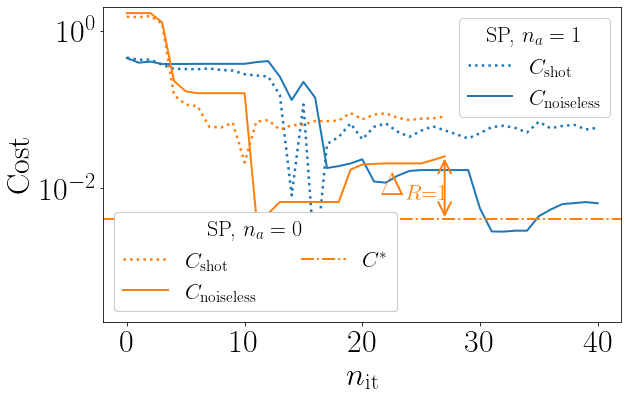

In [11]:
def get_rolling_mins(costs, window=10):
    """
    
    """
    mins = []
    bins = int(np.floor(len(costs) / window))
    for b in range(bins):
        cost_window = costs[b * window:(b + 1) * window]
        mins.append(min(cost_window))
        
    cost_window = costs[(bins + 1) * window:]
    if cost_window != []:
        mins.append(min(cost_window))
    
    return np.array(mins)

R = 2
R2_shot, R2_exact, R2_rho, R2_sigma, R2_np = data_dict["belem_1q_hadamard_prep_run"]
R2_opt = compute_optimal_DHS(R2_rho, R)

R = 1
R1_shot, R1_exact, R1_rho, R1_sigma, R1_np = data_dict["belem_1q_hadamard_prep_run_rank1_approx"]
R1_opt = compute_optimal_DHS(R1_rho, R)

width = 5.8
fig = plt.figure(figsize=(1.6 * width, width))
c = new_colors[0]
#R2_shot = list(np.abs(R2_shot))
g1, = plt.plot(np.abs(get_rolling_mins(R2_shot, R2_np)), label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
g2, = plt.plot(get_rolling_mins(R2_exact, R2_np), label=r"$C_{\text{noiseless}}$", color=c)
#plt.plot(get_rolling_mins(R1_shot, R1_np) + (1.02 - np.real(R1_rho.purity())), label=r"$C_{shot}, R=1$", color=c, linestyle=":", linewidth=2.5)
#R1_shot = list(np.abs(R1_shot))
c = new_colors[1]
f1, = plt.plot(np.abs(get_rolling_mins(R1_shot, R1_np)), label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
f2, = plt.plot(get_rolling_mins(R1_exact, R1_np), label=r"$C_{\text{noiseless}}$", color=c)
f3 = plt.axhline(R1_opt, 0, 10, label=r"$C^*$", color=c, linestyle="-.")

plt.rcParams['legend.title_fontsize'] = 'x-small'
legend1 = plt.legend(handles=[g1, g2], fontsize="x-small", title="SP, $n_a = 1$", loc=1)
plt.gca().add_artist(legend1)
plt.rcParams['legend.title_fontsize'] = 'x-small'
legend2 = plt.legend(handles=[f1, f2, f3], fontsize="x-small", title="SP, $n_a = 0$", loc=3, ncol=2)
plt.gca().add_artist(legend2)

R1_exact = get_rolling_mins(R1_exact, R1_np)[-1]
plt.annotate(
# Label and coordinate
r"", xy=(27, R1_opt),xytext=(27, R1_exact),
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='<->',lw=2,color=c),
multialignment='right'
)

plt.annotate(
# Label and coordinate
r"$\Delta_{R = 1}$", xy=(24.5, R1_opt),xytext=(24.5, R1_opt + (R1_exact - R1_opt) / 5),
horizontalalignment="center", color=c
)

plt.ylim(2e-4, 2)


plt.yscale("log")
plt.ylabel("Cost")
plt.xlabel(r"$n_{\text{it}}$")
plt.savefig("plots/belem_SP_additional_result_1q_noise_state.pdf", dpi=800, bbox_inches = 'tight')
plt.show()

In [12]:
R = 2
R2_shot, R2_exact, R2_rho, R2_sigma, R2_np = data_dict["belem_1q_hadamard_prep_run"]
R2_opt = compute_optimal_DHS(R2_rho, R)

R = 1
R1_shot, R1_exact, R1_rho, R1_sigma, R1_np = data_dict["belem_1q_hadamard_prep_run_rank1_approx"]
R1_opt = compute_optimal_DHS(R1_rho, R)

get_rolling_mins(R2_exact, R2_np)[-1]

0.0064446221254765845

In [13]:
get_rolling_mins(R1_exact, R1_np)[-1]

0.02529410839109003

In [14]:
R1_opt

0.004057495070829372

In [15]:
0.02529410839109003 - R1_opt

0.02123661332026066

In [16]:
min(R1_exact)

0.004258835642402925

In [17]:
min(R1_exact) - R1_opt

0.00020134057157355275

## Make Aliza CCPS rank 1, rank 2 plots w/ random state

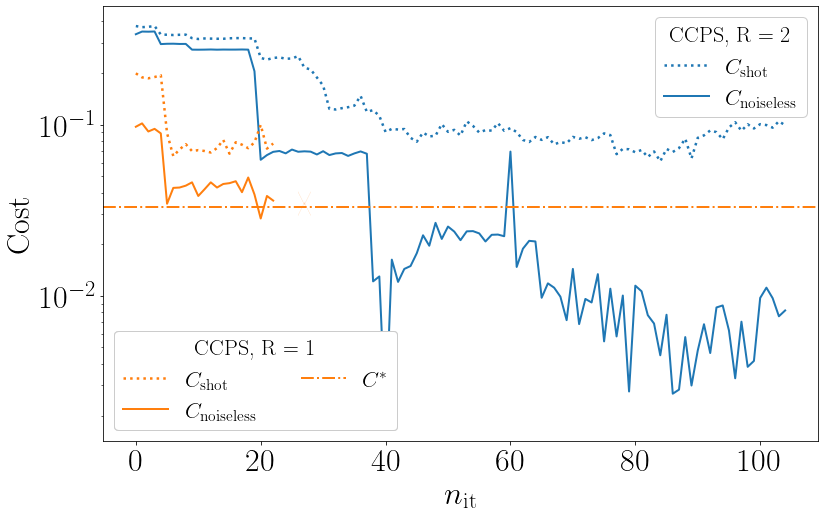

In [18]:
# must generate rho from the parameters of the circuit
R1_rho_params = [6.12073495, 1.16120667, 3.38216267, 3.49973899, 1.8877114, 3.77717022,
 1.57383566, 0.656488,   3.68852582, 2.96791314, 2.84928064, 3.38561463,
 5.38226244, 0.30773205, 2.14503341]
fa = FlexibleAnsatz(2, 'hef2d')
fa.update_parameters(R1_rho_params)
circ = fa.build_circ(2)
psi = circ.get_statevector()
R1_rho = qiskit.quantum_info.partial_trace(psi, [0])
R1_opt = compute_optimal_DHS(R1_rho, 1)

ddir = "hardware_implementation_data/aliza_hardware_data"
ccps_R1_shot_cost = []
with open(f"{ddir}/rank_1_shot_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R1_shot_cost.append(float(l))
        
ccps_R1_exact_cost = []
with open(f"{ddir}/rank_1_exact_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R1_exact_cost.append(float(l))
        
R2_rho_params = [3.18893189, 6.27124987, 2.22112546, 1.47919731, 0.87348005, 2.96821423,
 6.10530066, 3.79836755, 6.11363481, 5.52379821, 1.69065155, 5.11802006,
 5.74336996, 4.01688969, 5.67435184]
fa = FlexibleAnsatz(2, 'hef2d')
fa.update_parameters(R2_rho_params)
circ = fa.build_circ(2)
psi = circ.get_statevector()
R2_rho = qiskit.quantum_info.partial_trace(psi, [0])
R2_opt = compute_optimal_DHS(R2_rho, 2)

ccps_R2_shot_cost = []
with open(f"{ddir}/rank_2_shot_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R2_shot_cost.append(float(l))
        
ccps_R2_exact_cost = []
with open(f"{ddir}/rank_2_exact_cost.txt", 'r') as f:
    for l in f.readlines():
        ccps_R2_exact_cost.append(float(l))
        
width = 8
fig = plt.figure(figsize=(1.6 * width, width))
c = new_colors[0]
ccps_p1, = plt.plot(get_rolling_mins(ccps_R2_shot_cost, 4), label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
ccps_p2, = plt.plot(get_rolling_mins(ccps_R2_exact_cost, 4), label=r"$C_{\text{noiseless}}$", color=c)
c = new_colors[1]
ccps_p3, = plt.plot(get_rolling_mins(ccps_R1_shot_cost, 4), label=r"$C_{\text{shot}}$", color=c, linestyle=":", linewidth=2.5)
ccps_p4, = plt.plot(get_rolling_mins(ccps_R1_exact_cost, 4), label=r"$C_{\text{noiseless}}$", color=c)
f3 = plt.axhline(R1_opt, 0, 10, label=r"$C^*$", color=c, linestyle="-.")

plt.rcParams['legend.title_fontsize'] = 'x-small'
legend1 = plt.legend(handles=[ccps_p1, ccps_p2], fontsize="x-small", title="CCPS, R = 2", loc=1)
plt.gca().add_artist(legend1)
plt.rcParams['legend.title_fontsize'] = 'x-small'
legend2 = plt.legend(handles=[ccps_p3, ccps_p4, f3], fontsize="x-small", title="CCPS, R = 1", loc=3, ncol=2)
plt.gca().add_artist(legend2)
plt.yscale("log")

R1_exact = get_rolling_mins(ccps_R1_exact_cost, 4)[-1]
plt.annotate(
# Label and coordinate
r"", xy=(27, R1_opt),xytext=(27, R1_exact),
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='<->',lw=0.1,color=c),
multialignment='right'
)

#plt.annotate(
# Label and coordinate
#r"$\Delta_{R = 1}$", xy=(24.5, R1_opt),xytext=(24.5, R1_opt + (R1_exact - R1_opt) / 5),
#horizontalalignment="center", color=c
#)

plt.yscale("log")
plt.ylabel("Cost")
plt.xlabel(r"$n_{\text{it}}$")
plt.savefig("plots/additional_ccps_result_random_1q_state.pdf", dpi=800, bbox_inches = 'tight')
plt.show()

In [19]:
ccps_R2_exact_cost[-1]

0.00821830842722137

In [20]:
ccps_R1_exact_cost[-1]

0.043085

In [21]:
R1_opt

0.033149689573344424

In [22]:
ccps_R1_exact_cost[-1] - R1_opt

0.009935310426655575